In [1]:
import csv
import sys
import glob, os
import copy
import gc
from tqdm import tqdm
import time
import math
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon, Point
import shapely.wkt
import shapely.affinity
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
import rasterio.mask
import gdal
import ogr
import numpy as np
import random
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
import psutil
sys.setrecursionlimit(10**6)
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from torchsummary import summary
#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import albumentations as albu

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [3]:
#  get data list
path_3band = '../building_detection_data/3band_train/3band/'
path_8band = '../building_detection_data/8band_train/8band/'
path_3band_test = '../building_detection_data/3band_test/'
path_8band_test = '../building_detection_data/8band_test/'
path_geojson = '../building_detection_data/geojson_train/'
path_mask_img = '../building_detection_data/MaskImages/'

def get_list(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

list_3band = get_list(path_3band)
list_8band = get_list(path_8band)
list_geojson = get_list(path_geojson)

list_3band_test = get_list(path_3band_test)
list_8band_test = get_list(path_8band_test)

open sat imgs trial

(448, 448, 3)


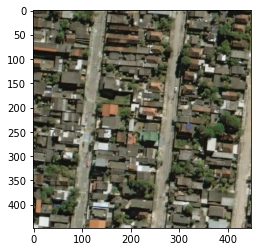

In [4]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(448, 448), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [5]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,0].max()

242

(224, 224, 3)


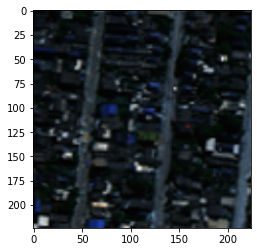

In [6]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
data = np.stack([data[:,:,1], data[:,:,2], data[:,:,4]], axis=2)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [7]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,6].max()

6265

In [8]:
import os
print(len(os.listdir("../building_detection_data/3band_train/3band")))
print(len(os.listdir("../building_detection_data/8band_train/8band")))
print(len(os.listdir("../building_detection_data/MaskImages")))
print(len(os.listdir("../building_detection_data/3band_test")))
print(len(os.listdir("../building_detection_data/8band_test")))

6940
6940
6940
2795
2795


(406, 439, 1)


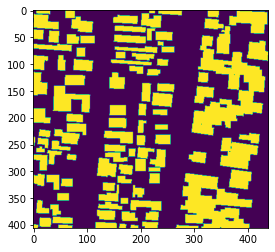

In [9]:
mask = rio.open('../building_detection_data/MaskImages/AOI_1_RIO_img3745.tif')
data = mask.read()
data = data.transpose(1,2,0)
print(data.shape)
mask = np.array(data)
plt.imshow(mask)

create mask images

In [10]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(range(1, file_count + 1)):

        src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
        src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)
        dst_filename = "AOI_1_RIO_img{}.tif".format(idx)

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [11]:
#build_labels(path_3band, path_geojson, path_mask_img)

In [12]:
list_masks = get_list(path_mask_img)

list_3band = sorted(list_3band)
list_8band = sorted(list_8band)
list_3band_test = sorted(list_3band_test)
list_8band_test = sorted(list_8band_test)
list_masks = sorted(list_masks)

In [13]:
#  resize images
s = 224
N = len(list_3band)

def standardize(img):
    mean = img.mean()
    std = img.std()
    if(std != 0):
        img = (img - mean) / std
    return img    

def resize_images(list, path):
    images = []
    for i in tqdm(list):
        im = rio.open(path + i)
        im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
        if im.max()!=0:
            im = im / im.max()
        #im = standardize(im)
        images.append(im)
    return images

# # added by yoshioka 2021/06/05
# def resize_images_8band_to_4band(list, path):
#     images = []
#     for i in tqdm(list):
#         im = rio.open(path+i)
#         im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
#         if im.max()!=0:
#             im = im / im.max()
#         im = np.stack([im[1,:,:], im[2,:,:], im[4,:,:], im[6,:,:]], axis=0)
#         images.append(im)
#     return images

# added by yoshioka 2021/06/05
def resize_images_make_4band(list_3band, list_8band, three_band_path, eight_band_path):
    images = []
    for i, j in tqdm(zip(list_3band, list_8band)):
        im_3band = rio.open(three_band_path+i)
        im_8band = rio.open(eight_band_path+j)
        im_3band = im_3band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        im_8band = im_8band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        
        im_3band = np.array(im_3band)
        im_3band = im_3band / im_3band.max()
        
        im_8band = np.array(im_8band)
        im_8band = im_8band / im_8band.max()
        
        im_cat = np.stack([im_3band[0,:,:], im_3band[1,:,:], im_3band[2,:,:], im_8band[6,:,:]], axis=0)
        # --------------warning-----------------
        # The following normalization causes the images to be very dark!!
        if im_cat.max()!=0:
            im_cat = im_cat / im_cat.max()

        # im_cat = standardize(im_cat) # -> it causes wrong result
        images.append(im_cat)
    return images

# revised by yoshioka 2021/06/05
# to change the 3 band images to 4 band images
# by adding NIR in 8 band images
def get_batch_imgs(b, lists=[list_3band, list_8band], paths=[path_3band, path_8band]):
    out = np.zeros((N, b, s, s))
    if b == 8:
        for i, img in tqdm(enumerate(resize_images(lists[1], paths[1]))):
            out[i,:,:,:] = img
    elif b == 3:
        for i, img in tqdm(enumerate(resize_images(lists[0], paths[0]))):
            out[i,:,:,:] = img
    elif b == 4:
        for i, img in tqdm(enumerate(resize_images_make_4band(lists[0], lists[1], paths[0], paths[1]))):
            out[i,:,:,:] = img
    else:
        print("ERROR IN BAND NUMBER!")
    return out

def get_batch_masks(list, path):
    out = np.zeros((N, s, s))
    for i, img in tqdm(enumerate(resize_images(list, path))):
        out[i,:,:] = img
    return out

# def concat_band(list3, list8):
#     out = np.zeros((N, 11, s, s))
#     for i, (j, k) in tqdm(enumerate(zip(list3, list8))):
#         im = np.concatenate([j,k],0)
#         out[i,:,:,:] = im
#     return out

dataset / dataloader

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.nn import functional as F
from torchvision import transforms
import albumentations as album
import random
import cv2

def preprocess(x, y):
    #x = x / MAX
    x = torch.from_numpy(x.astype('float32'))#.permute(1,2,0)
    if y is not None:
        y = torch.from_numpy(y.astype('float32'))#.permute(1,2,0)
        #y = F.one_hot(y, num_classes=2).permute(2,0,1)
    return x, y
    
def get_augmentation():
    border = cv2.BORDER_CONSTANT
    transform = [
        #album.Blur(),
        #album.OpticalDistortion(distort_limit=2, border_mode=border),
        #album.ElasticTransform(alpha=50, border_mode=border),
        #album.Rotate(limit=15, border_mode=border),
        album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0.5, border_mode=border),
        #album.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0, border_mode=border),
        album.imgaug.transforms.IAAAffine(shear=10, mode='constant'),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5), # 反転する代わりに色が変化している？
        #album.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=20, always_apply=False, p=0.5),
    ]
    return album.Compose(transform, p=1.0)


def get_augmentation():
    border = cv2.BORDER_CONSTANT
    transform = [
        album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0.5, border_mode=border),
        album.imgaug.transforms.IAAAffine(shear=10, mode='constant'),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(transform, p=1.0)


def get_loader(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size, shuffle)

class SatelliteDatasetFor4Band(Dataset):
    def __init__(self, img_3band_dir, img_8band_dir, mask_dir, augmentations, img_3band_ids, img_8band_ids, mask_ids, shape):
        super().__init__()
        self.img_3band_dir = img_3band_dir
        self.img_8band_dir = img_8band_dir
        self.mask_dir = mask_dir
        self.augmentations = augmentations
        self.img_3band_ids = img_3band_ids
        self.img_8band_ids = img_8band_ids
        self.mask_ids = mask_ids
        self.shape = shape
        assert len(img_3band_ids) == len(img_8band_ids), 'lengths of 3band and 8band datasets are not equal'
        assert len(img_3band_ids) == len(mask_ids), 'lengths of 3band and masks datasets are not equal'
        assert len(img_8band_ids) == len(mask_ids), 'lengths of 8band and masks datasets are not equal'
        self.data_size = len(img_3band_ids)
        
    def __len__(self):
        return self.data_size
        
    def __getitem__(self, index):
        img_3band_id, img_8band_id, mask_id = self.img_3band_ids[index], self.img_8band_ids[index], self.mask_ids[index]
        
        img_3band = rio.open(self.img_3band_dir + '/' + img_3band_id)
        img_8band = rio.open(self.img_8band_dir + '/' + img_8band_id)
        mask = rio.open(self.mask_dir + '/' + mask_id)
        
        img_3band = img_3band.read(out_shape=(self.shape, self.shape), resampling=Resampling.bilinear).astype('float32')
        img_8band = img_8band.read(out_shape=(self.shape, self.shape), resampling=Resampling.bilinear).astype('float32')
        mask = mask.read(out_shape=(self.shape, self.shape), resampling=Resampling.bilinear).astype('float32')
        
        img_3band = np.array(img_3band)
        if img_3band.max() != 0:
            img_3band = img_3band / img_3band.max()
        
        img_8band = np.array(img_8band)
        if img_8band.max() != 0:
            img_8band = img_8band / img_8band.max()
        
        img_4band = np.stack([img_3band[0,:,:], img_3band[1,:,:], img_3band[2,:,:], img_8band[6,:,:]], axis=0)
        
        if img_4band.max() != 0:
            img_4band = img_4band / img_4band.max()
        
        if mask.max() != 0:
            mask = mask / mask.max()
        
        if self.augmentations is not None:
            img_4band = img_4band.transpose(2,1,0)
            mask = mask.transpose(2,1,0)
            aug = self.augmentations(image=img_4band, mask=mask)
            img, mask = aug['image'], aug['mask']
            img, mask = preprocess(img, mask)
            img = img.permute(2,1,0)
            mask = mask.permute(2,1,0)
        else:
            img, mask = preprocess(img_4band, mask)
        return img, mask

In [15]:
building_satimg_dataset = SatelliteDatasetFor4Band(img_3band_dir=path_3band, img_8band_dir=path_8band, mask_dir=path_mask_img, augmentations=None, img_3band_ids=list_3band, img_8band_ids=list_8band, mask_ids=list_masks, shape=224)
print(building_satimg_dataset.__len__())

6940


In [16]:
img, mask = building_satimg_dataset.__getitem__(1200)
img.shape, mask.shape

(torch.Size([4, 224, 224]), torch.Size([1, 224, 224]))

(224, 224, 3)


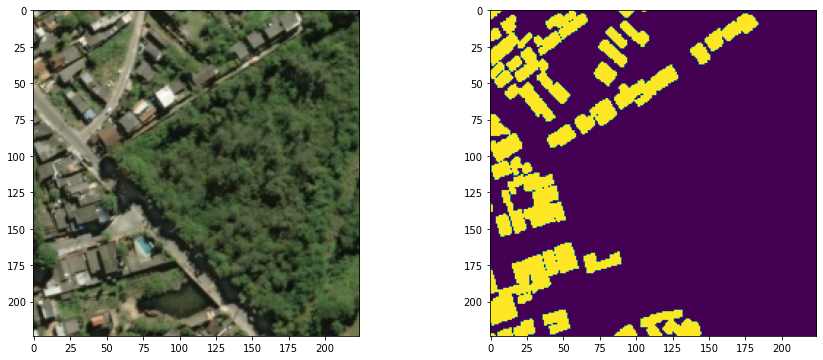

In [17]:
img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
print(img.shape)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(img)
axes[1].imshow(mask)

torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
(224, 224, 3)


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:337: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


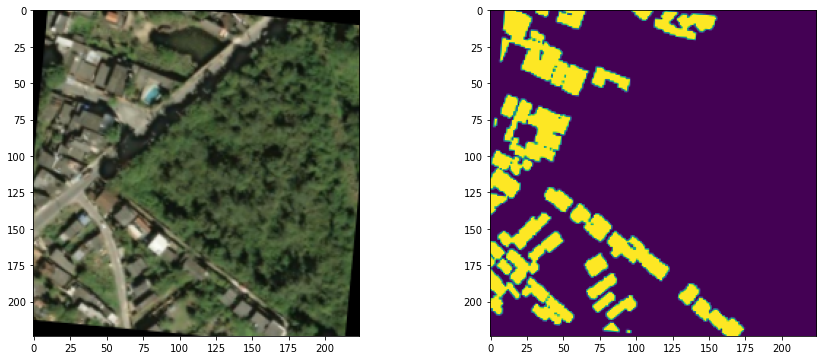

In [18]:
building_satimg_dataset_augmentated = SatelliteDatasetFor4Band(img_3band_dir=path_3band, img_8band_dir=path_8band, mask_dir=path_mask_img, augmentations=get_augmentation(), img_3band_ids=list_3band, img_8band_ids=list_8band, mask_ids=list_masks, shape=224)

img, mask = building_satimg_dataset_augmentated.__getitem__(1200)
print(img.shape, mask.shape)

img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
print(img.shape)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(img)
axes[1].imshow(mask)

albumentations test

(448, 448, 3) <class 'numpy.ndarray'>


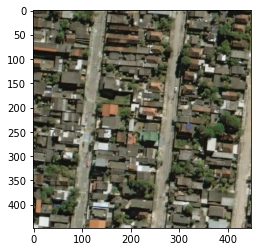

In [19]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(448, 448), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
if data.max()!= 0:
    data = data / data.max()
print(data.shape, type(data))

transform = album.Compose([
    album.VerticalFlip(p=0.5),
    album.HorizontalFlip(p=0.5),
    #album.Blur(),
    #album.imgaug.transforms.IAAAffine(shear=10, mode='constant'),
], p=0.5)

transformed = transform(image=data)
transformed_img = transformed["image"]
img = np.array(transformed_img)
plt.imshow(img) # album works fine.

In [20]:
img = img.transpose(2,1,0)
print(img.shape)
img = img.transpose(1,2,0)
print(img.shape)

(3, 448, 448)
(448, 448, 3)


concatnate dataset

torch.Size([4, 224, 224]) torch.Size([1, 224, 224])
(224, 224, 3)


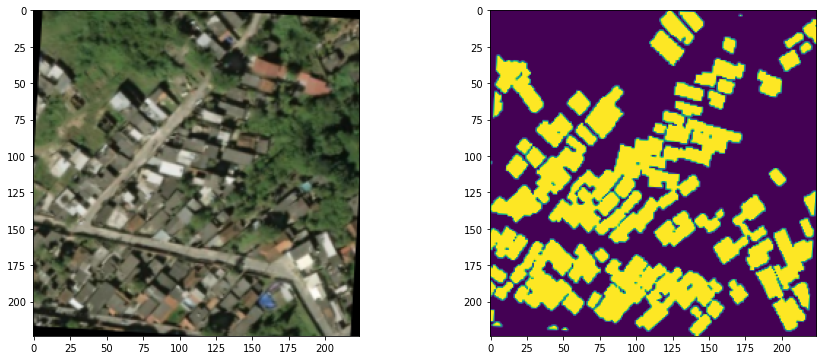

In [21]:
img, mask = building_satimg_dataset_augmentated.__getitem__(1202)
print(img.shape, mask.shape)

img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2]], axis=2)
print(img.shape)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(img)
axes[1].imshow(mask)

In [22]:
from torch.utils.data.dataset import ConcatDataset
building_satimg_dataset_concatnated = ConcatDataset([building_satimg_dataset, building_satimg_dataset_augmentated])
print(building_satimg_dataset_concatnated.__len__())

13880


In [23]:
from torch.utils.data.dataset import Subset

n_samples = len(building_satimg_dataset_concatnated)
train_size = int(n_samples * 0.8)

train_subset_indices = list(range(0, train_size))
val_subset_indices = list(range(train_size,n_samples))

train_dataset = Subset(building_satimg_dataset_concatnated, train_subset_indices)
val_dataset = Subset(building_satimg_dataset_concatnated, val_subset_indices)

train_4b_loader = get_loader(dataset=train_dataset, batch_size=16, shuffle=True)
val_4b_loader = get_loader(dataset=val_dataset, batch_size=1, shuffle=False)

In [24]:
#  configure
criterion = nn.BCELoss()

#  Metrics
epsilon = 1e-6
def IoU(pred, mask):
    pred = pred.cpu().numpy().astype(int)
    mask = mask.cpu().numpy().astype(int)
    intersection = (pred & mask).sum()
    union = (pred | mask).sum()
    out = (intersection + epsilon) / (union + epsilon)
    return out

In [25]:
# Early stopping
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [26]:
#  U-Net Model
#  https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()
        
        self.dconv_down1 = double_conv(input_ch, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = double_conv(256+512, 256)
        self.dconv_up2 = double_conv(128+256, 128)
        self.dconv_up1 = double_conv(64+128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

model = UNet(4, 1)
model = model.to(device)  

from torchsummary import summary
summary(model, (4, 224, 224))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           2,368
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [27]:
#  train 
def train(model, optimizer, train_loader, val_loader, epochs):
    model.train()
    log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]}
    early_stopping = EarlyStopping(5, True)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_iou = 0
        for data, mask in train_loader:
            data, mask = data.to(device), mask.to(device)
            mask = mask.view(-1)
            out = model(data)
            out = torch.sigmoid(out)
            out = out.view(-1)
            loss = criterion(out, mask)
            pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
            iou = IoU(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.item())
            epoch_iou += float(iou.item())
        epoch_loss = epoch_loss / len(train_loader)
        epoch_iou = epoch_iou / len(train_loader)
        log["train_loss"].append(epoch_loss)
        log["train_iou"].append(epoch_iou)
        
        # validation
        val_loss = 0
        val_iou = 0
        with torch.no_grad():
            for data, mask in val_loader:
                data, mask = data.to(device), mask.to(device)
                mask = mask.view(-1)
                out = model(data)
                out = torch.sigmoid(out)
                out = out.view(-1)
                loss = criterion(out, mask)
                pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
                iou = IoU(pred, mask)
                val_loss += float(loss.item())
                val_iou += float(iou.item())
        val_loss = val_loss / len(val_loader)
        val_iou = val_iou / len(val_loader)
        log["val_loss"].append(val_loss)
        log["val_iou"].append(val_iou)
        print('epoch{}:終了  train_loss={}, train_iou={}, val_loss={}, val_iou={}\n'.format(epoch, epoch_loss, epoch_iou, val_loss, val_iou))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(log["train_loss"], color='orangered', label='train')
    plt.plot(log["val_loss"], color='cyan', label='val')
    plt.legend(loc=0)
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('iou')
    plt.plot(log["train_iou"], color='orangered', label='train')
    plt.plot(log["val_iou"], color='cyan', label='val')
    plt.legend(loc=0)
    plt.show()
    fig.savefig("img/train_log.png")
    return log
    
        
#  test
threshold = 0.5
def test(model, load_test):
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()
    test_loss = 0
    test_iou = 0
    for data, mask in tqdm(load_test):
        data, mask = data.to(device), mask.to(device)
        mask = mask.view(-1)
        out = model(data)
        out = torch.sigmoid(out)
        out = out.view(-1)
        loss = criterion(out, mask)
        test_loss += float(loss.item())
        pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
        #pred_np = pred.to('cpu').detach().numpy().copy().reshape(224,224)
        #pred = morphology.binary_closing(pred_np, morphology.diamond(1)).astype(np.uint8)
        #pred = torch.from_numpy(pred).view(-1).to(device)
        iou = IoU(pred, mask)
        test_iou += float(iou.item())
    test_loss = test_loss/len(load_test)
    test_iou = test_iou/len(load_test)
    print('テスト終了  test_loss={},  test_iou={}'.format(test_loss, test_iou))

In [28]:
#  execute train
model = UNet(4, 1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]} 
log = train(model, optimizer, train_4b_loader, val_4b_loader, 30)

  0%|          | 0/30 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 588.00 MiB (GPU 0; 11.92 GiB total capacity; 2.11 GiB already allocated; 221.81 MiB free; 2.94 GiB reserved in total by PyTorch)

# Masuda urban areas

In [ ]:
image1 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20201112_Masuda_Urban.TIF'
image2 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20210315_Masuda_Urban.TIF'

psh1 = rio.open(image1)
psh1_meta = psh1.meta
psh1 = psh1.read().transpose([1,2,0]).astype('float')

psh2 = rio.open(image2)
psh2_meta = psh2.meta
psh2 = psh2.read().transpose([1,2,0]).astype('float')

In [ ]:
psh1.shape

In [ ]:
# Image check
import utils
def stack_3band(img, i=1, j=2, k=4, gray=False):
    '''
    False color visuliazation
    [1,2,4] - RGB
    [7,3,1] - cement
    '''
    img_3band = np.stack([img[:, :, i],
                         img[:, :, j],
                         img[:, :, k]], axis=2)
    img_gray = (img[:, :, i] + img[:, :, j] + img[:, :, k]) / 3
    if gray:
        return img_gray[:, :, np.newaxis].astype('int32')
    else:
        return img_3band

psh_rgb1 = stack_3band(psh1, 0,1,2)
psh_rgb2 = stack_3band(psh2, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(psh_rgb2))

In [ ]:
psh_rgb1.shape

In [ ]:
_psh_rgb1 = psh_rgb1[1000:1000+224*1, 1000:1000+224*1]
_psh_rgb2 = psh_rgb2[1000:1000+224*1, 1000:1000+224*1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(_psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(_psh_rgb2))

In [ ]:
_psh1 = psh1[1000:1000+224*1, 1000:1000+224*1, :]
# _psh1 = psh1[1000:1000+448, 1000:1000+448, :]
# img = Image.fromarray(np.uint8(_psh1))
# _psh1 = np.asarray(img.resize((224,224)))

_psh1.shape

In [ ]:
#_psh1 = np.array(_psh1)
_psh1 = _psh1.transpose(2,0,1)
_psh1 = _psh1[np.newaxis,:,:,:]

In [ ]:
pred = model(torch.from_numpy(_psh1.astype(np.float32)).to(device))
pred = pred.cpu().detach().numpy().squeeze()
pred = np.where(pred>=0.5, 1, 0)
plt.imshow(pred)

In [ ]:
type(_psh1)